# Лабораторная работа №2
## Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных
### Выполнил Плешаков Владислав, РТ5-61Б

Датасет: https://www.kaggle.com/competitions/spaceship-titanic/data
Описание датасета:
* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always (string)
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence (string)
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins (True/False)
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard (string)
* **Destination** - The planet the passenger will be debarking to (string)
* **Age** - The age of the passenger (int)
* **VIP** - Whether the passenger has paid for special VIP service during the voyage (True/False)**
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities (float)
* **Name** - The first and last names of the passenger (string)
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict (True/False)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

%matplotlib inline
sns.set(style="ticks")

In [2]:
data = pd.read_csv('data/train.csv', sep=',')

In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## Обработка пропусков в данных

### Удаление строк и столбцов с пропусками

In [6]:
# Удаление строк
data_del_row: pd.DataFrame = data.dropna(axis=0, how='any', subset=['Destination', 'VRDeck'])

# Удаление столбцов
data_deleted: pd.DataFrame = data_del_row.drop(axis=1, columns=['Name', 'PassengerId', 'ShoppingMall', 'Spa', 'Cabin'])

In [7]:
data_deleted.isnull().sum()

HomePlanet     196
CryoSleep      206
Destination      0
Age            172
VIP            198
RoomService    176
FoodCourt      171
VRDeck           0
Transported      0
dtype: int64

### Обработка пропусков в числовых данных

In [8]:
# Выберем числовые колнки с пропусками
num_cols = []
total_count = data_deleted.shape[0]
for col in data_deleted.columns:
    temp_null_count = data_deleted[data_deleted[col].isnull()].shape[0]
    dt = str(data_deleted[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Age. Тип данных float64. Количество пустых значений 172, 2.07%.
Колонка RoomService. Тип данных float64. Количество пустых значений 176, 2.11%.
Колонка FoodCourt. Тип данных float64. Количество пустых значений 171, 2.05%.


In [9]:
data_num = data_deleted[num_cols]
data_num

,Age,RoomService,FoodCourt
0,39.0,0.0,0.0
1,24.0,109.0,9.0
2,58.0,43.0,3576.0
3,33.0,0.0,1283.0
4,16.0,303.0,70.0
...,...,...,...
8688,41.0,0.0,6819.0
8689,18.0,0.0,0.0
8690,26.0,0.0,0.0
8691,32.0,0.0,1049.0


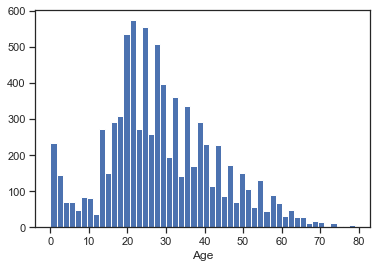

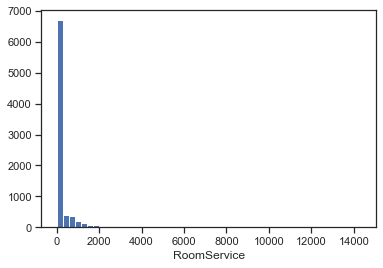

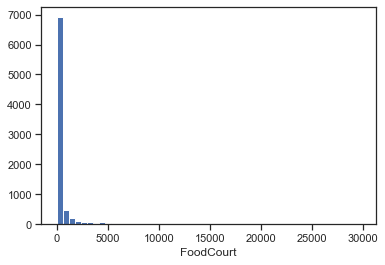

In [10]:
for col in data_num:
    plt.hist(data_deleted[col], 50)
    plt.xlabel(col)
    plt.show()

In [11]:
data_age = data_num[['Age']]
data_age.head()

,Age
0,39.0
1,24.0
2,58.0
3,33.0
4,16.0


In [12]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_age)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [13]:
# Функция для заполнения пропусков с выбором колонки и стратегии
def impute_num_dataframe(df, col_name, strategy_name) -> pd.DataFrame:
    temp_data = df.copy()
    imp = SimpleImputer(strategy=strategy_name)
    data_imputed = imp.fit_transform(temp_data[[col_name]])
    temp_data[[col_name]] = data_imputed
    return temp_data

In [14]:
# Заполним пропуски в колонке Age с применением различных стратегий
data_age_imp_mean = impute_num_dataframe(data_deleted, 'Age', 'mean')
data_age_imp_median = impute_num_dataframe(data_deleted, 'Age', 'median')
data_age_imp_moda = impute_num_dataframe(data_deleted, 'Age', 'most_frequent')

In [15]:
# Посмотрим, какими значениями заполнились пропуски
pd.concat([data_age_imp_mean[mask_missing_values_only]['Age'],
           data_age_imp_median[mask_missing_values_only]['Age'],
           data_age_imp_moda[mask_missing_values_only]['Age']], axis=1)

,Age,Age,Age
50,28.822151,27.0,24.0
64,28.822151,27.0,24.0
137,28.822151,27.0,24.0
181,28.822151,27.0,24.0
184,28.822151,27.0,24.0
...,...,...,...
8274,28.822151,27.0,24.0
8301,28.822151,27.0,24.0
8374,28.822151,27.0,24.0
8407,28.822151,27.0,24.0


(array([306., 175.,  87., 121., 221., 284., 599., 834., 549., 984., 507.,
        592., 505., 335., 462., 347., 229., 258., 220., 105., 189.,  88.,
        113.,  81.,  50.,  32.,  22.,  11.,  11.,   8.]),
 array([ 0.        ,  2.63333333,  5.26666667,  7.9       , 10.53333333,
        13.16666667, 15.8       , 18.43333333, 21.06666667, 23.7       ,
        26.33333333, 28.96666667, 31.6       , 34.23333333, 36.86666667,
        39.5       , 42.13333333, 44.76666667, 47.4       , 50.03333333,
        52.66666667, 55.3       , 57.93333333, 60.56666667, 63.2       ,
        65.83333333, 68.46666667, 71.1       , 73.73333333, 76.36666667,
        79.        ]),
 <BarContainer object of 30 artists>)

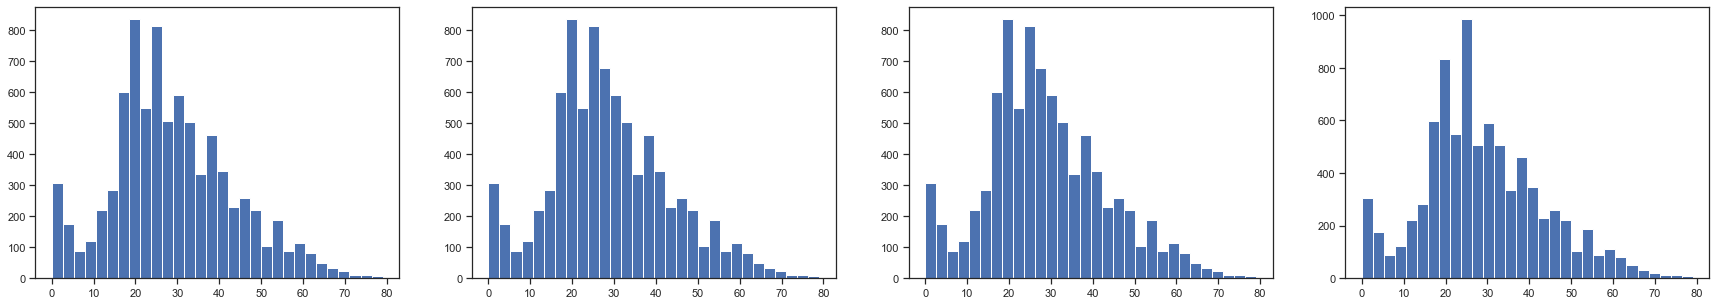

In [16]:
# Сравним полученные гистограммы
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,5))
ax1.hist(data_deleted['Age'], bins=30)
ax2.hist(data_age_imp_mean['Age'], bins=30)
ax3.hist(data_age_imp_median['Age'], bins=30)
ax4.hist(data_age_imp_moda['Age'], bins=30)


In [17]:
# Заполним пропуски в колонках RoomService и FoodCourt
data_food_imp = impute_num_dataframe(data_deleted, 'FoodCourt', 'most_frequent')
data_room_imp = impute_num_dataframe(data_deleted, 'RoomService', 'most_frequent')

In [18]:
data_num_imputed = data_deleted.copy()
data_num_imputed['Age'] = data_age_imp_median['Age']
data_num_imputed['FoodCourt'] = data_food_imp['FoodCourt']
data_num_imputed['RoomService'] = data_room_imp['RoomService']
data_num_imputed.isnull().sum()

HomePlanet     196
CryoSleep      206
Destination      0
Age              0
VIP            198
RoomService      0
FoodCourt        0
VRDeck           0
Transported      0
dtype: int64

### Обработка пропусков в категориальных данных

In [19]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data_num_imputed.columns:
    # Количество пустых значений
    temp_null_count = data_num_imputed[data_num_imputed[col].isnull()].shape[0]
    dt = str(data_num_imputed[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка HomePlanet. Тип данных object. Количество пустых значений 196, 2.35%.
Колонка CryoSleep. Тип данных object. Количество пустых значений 206, 2.47%.
Колонка VIP. Тип данных object. Количество пустых значений 198, 2.38%.


In [20]:
# Найдем уникальные значения
data_num_imputed['HomePlanet'].unique(), data_num_imputed['CryoSleep'].unique(), data_num_imputed['VIP'].unique()

(array(['Europa', 'Earth', 'Mars', nan], dtype=object),
 array([False, True, nan], dtype=object),
 array([False, True, nan], dtype=object))

In [21]:
# Создадим SimpleImputer со стратегией most frequent
cat_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_planet_imp: np.ndarray = cat_imp.fit_transform(data_num_imputed[['HomePlanet']])
data_sleep_imp: np.ndarray = cat_imp.fit_transform(data_num_imputed[['CryoSleep']])
data_vip_imp: np.ndarray = cat_imp.fit_transform(data_num_imputed[['VIP']])
np.unique(data_planet_imp), np.unique(data_sleep_imp), np.unique(data_vip_imp)

(array(['Earth', 'Europa', 'Mars'], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object))

In [22]:
data_imputed: pd.DataFrame = data_num_imputed.copy()
data_imputed['HomePlanet'] = data_planet_imp
data_imputed['CryoSleep'] = data_sleep_imp
data_imputed['VIP'] = data_vip_imp

## Кодирование категориальных признаков

## Кодирование нецелевых признаков
Для кодирования нецелых признаков воспользуемся OrdinalEncoder

In [23]:
data_oe = data_imputed[['HomePlanet', 'CryoSleep', 'VIP', 'Destination']]
oe = OrdinalEncoder()
data_oe_coded = oe.fit_transform(data_oe)
data_oe_coded = pd.DataFrame(data_oe_coded, columns=oe.feature_names_in_)
data_oe_coded.head()

,HomePlanet,CryoSleep,VIP,Destination
0,1.0,0.0,0.0,2.0
1,0.0,0.0,0.0,2.0
2,1.0,0.0,1.0,2.0
3,1.0,0.0,0.0,2.0
4,0.0,0.0,0.0,2.0


Целевой признак Transported закодируем при помощи LabelEncoding

In [24]:
data_le = data_imputed['Transported']
le = LabelEncoder()
data_le_coded = le.fit_transform(data_le)
data_le_coded = pd.DataFrame(data_le_coded, columns=['Transported'])

In [25]:
data_proc: pd.DataFrame = data_imputed.copy()
data_proc = data_proc.drop(columns=['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Transported'])
data_proc = pd.concat([data_proc.reset_index(drop=True), data_oe_coded, data_le_coded], axis=1)
data_proc.head()

,Age,RoomService,FoodCourt,VRDeck,HomePlanet,CryoSleep,VIP,Destination,Transported
0,39.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
1,24.0,109.0,9.0,44.0,0.0,0.0,0.0,2.0,1
2,58.0,43.0,3576.0,49.0,1.0,0.0,1.0,2.0,0
3,33.0,0.0,1283.0,193.0,1.0,0.0,0.0,2.0,0
4,16.0,303.0,70.0,2.0,0.0,0.0,0.0,2.0,1


Изменим типы колонок HomePlanet, CryoSleep, Age, Vip и Transported на int64

In [26]:
data_proc = data_proc.astype({'HomePlanet': 'int64',
                  'CryoSleep': 'int64',
                  'Age': 'int64',
                  'VIP': 'int64',
                  'Destination': 'int64',
                  'Transported': 'int64'})
data_proc.head()

,Age,RoomService,FoodCourt,VRDeck,HomePlanet,CryoSleep,VIP,Destination,Transported
0,39,0.0,0.0,0.0,1,0,0,2,0
1,24,109.0,9.0,44.0,0,0,0,2,1
2,58,43.0,3576.0,49.0,1,0,1,2,0
3,33,0.0,1283.0,193.0,1,0,0,2,0
4,16,303.0,70.0,2.0,0,0,0,2,1


## Масштабирование данных

In [27]:
sc1 = MinMaxScaler()
sc2 = StandardScaler()
data_min_max_sc = sc1.fit_transform(data_proc[['Age']])
data_standard_sc = sc2.fit_transform(data_proc[['Age']])

<AxesSubplot:ylabel='Count'>

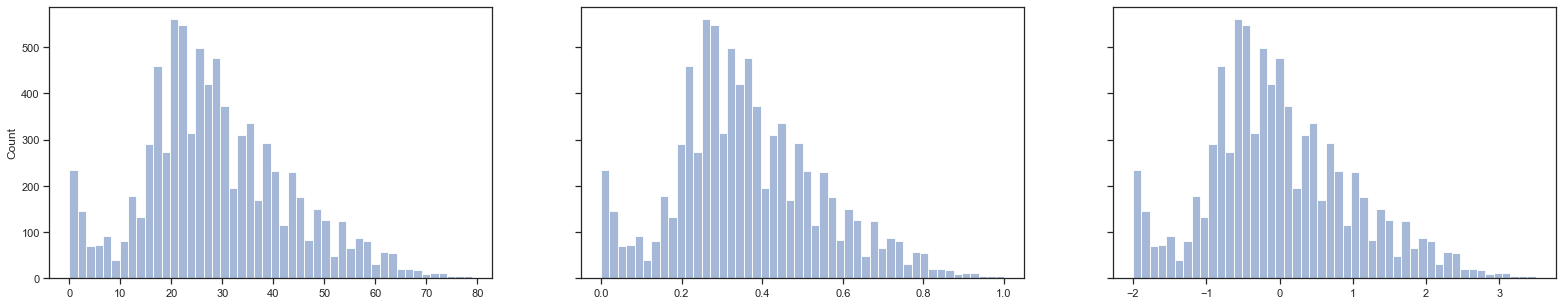

In [28]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(27, 5))
sns.histplot(data_proc[['Age']], ax=ax[0], legend=False)
sns.histplot(data_min_max_sc, ax=ax[1], legend=False)
sns.histplot(data_standard_sc, ax=ax[2], legend=False)